In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [3]:
X, y = make_regression(#we generate all the housing data
    n_samples=1200,
    n_features=10,
    n_informative=8,
    noise=20.0,
    random_state=42
)

feature_names = [
    "num_rooms",
    "area_sqft",
    "age",
    "distance_to_city_center",
    "num_bathrooms",
    "has_garage",
    "year_built",
    "lot_size",
    "school_quality",
    "crime_rate"
]


In [4]:
df = pd.DataFrame(X, columns=feature_names)
df["price"] = y

In [7]:
baseline = Pipeline([#pipeline
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

In [8]:
baseline_scores = cross_val_score(
    baseline,
    df[feature_names],
    df["price"],
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
baseline_mse = -baseline_scores.mean()

In [9]:
pipeline = Pipeline([
    ("poly", PolynomialFeatures()),
    ("select", SelectKBest(score_func=f_regression)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

In [10]:
param_grid = {
    "poly__degree": [1, 2],
    "select__k": [5, 8, 10, "all"],
    "ridge__alpha": [0.1, 1.0, 10.0]
}


In [11]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid.fit(df[feature_names], df["price"])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7a96af5742c0>)),
                                       ('scaler', StandardScaler()),
                                       ('ridge', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'poly__degree': [1, 2],
                         'ridge__alpha': [0.1, 1.0, 10.0],
                         'select__k': [5, 8, 10, 'all']},
             scoring='neg_mean_squared_error')

In [12]:
best_mse = -grid.best_score_
improvement_pct = (baseline_mse - best_mse) / baseline_mse * 100

print(f"Baseline MSE:    {baseline_mse:.2f}")
print(f"Best MSE:        {best_mse:.2f}")
print(f"Error reduced by {improvement_pct:.1f}%")

print("\nBest hyperparameters:")
for param, val in grid.best_params_.items():
    print(f"  {param}: {val}")

Baseline MSE:    395.31
Best MSE:        394.89
Error reduced by 0.1%

Best hyperparameters:
  poly__degree: 2
  ridge__alpha: 0.1
  select__k: 10


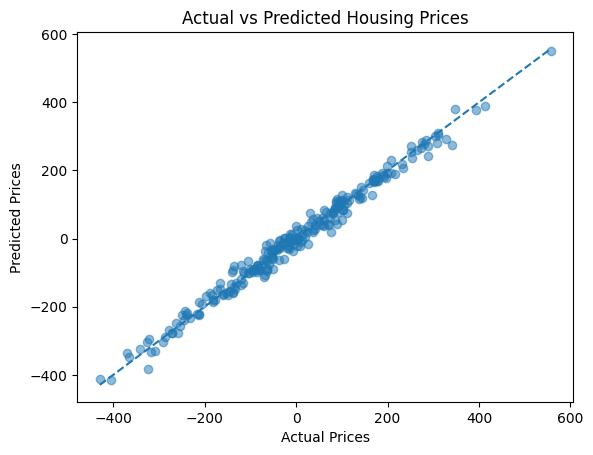

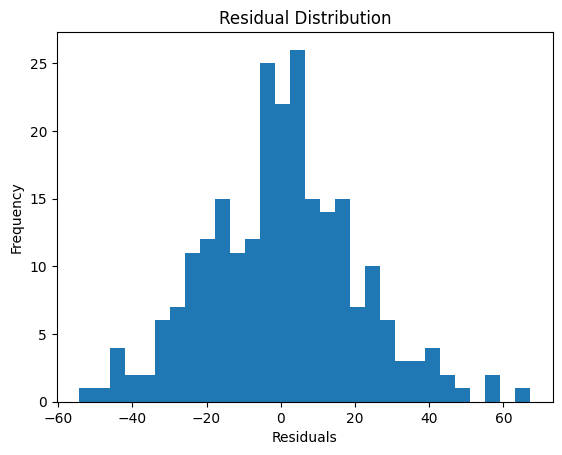

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1) Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names], df["price"],
    test_size=0.2, random_state=42
)

# 2) Fit the best pipeline
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# 3) Predict on test set
y_pred = best_model.predict(X_test)

# 4) Plot Actual vs Predicted
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         '--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices")
plt.show()

# 5) Plot Residual Distribution
residuals = y_test - y_pred
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()